11 5
11 6
12 5
12 6


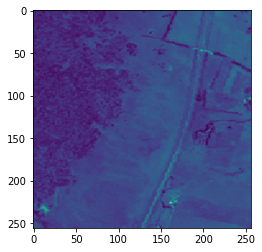

In [3]:
%matplotlib inline

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from pyproj import Transformer

wgs84_proj = "epsg:4326"
aea_proj = "epsg:3577"
wm_proj = "epsg:3857"

def geotransform(i,j):
    return (1506645+i*4000,10,0,-3932965-j*4000,0,-10)

def tiles(x,y):
    return int((x-1506645)/4000.), int((-3932965-y)/4000.)

def bbox2tiles(bbox):
    transformer = Transformer.from_crs(wm_proj, aea_proj)
    xs, ys = transformer.transform([bbox[0],bbox[2]], [bbox[3],bbox[1]])

    i0,j0=tiles(xs[0],ys[0])
    i1,j1=tiles(xs[1],ys[1])
    return (i0,i1,j0,j1)

#bbox=[16600899.551087722,-4207094.0368161,16603345.535992848,-4204648.051910976]
bbox=[16605791.520897973,-4202202.06700585,16608237.505803099,-4199756.082100724]
i0,i1,j0,j1 = bbox2tiles(bbox)

im_size = 256

pixel_size = ((bbox[2] - bbox[0]) / im_size, (bbox[3] - bbox[1]) / im_size)
    
tile_xs = np.arange(bbox[0], bbox[2], pixel_size[0])
tile_ys = np.arange(bbox[3], bbox[1], -pixel_size[1])
 
transformer = Transformer.from_crs(wm_proj, aea_proj)
aea_xs, aea_ys = transformer.transform(tile_xs, tile_ys)

arr = np.zeros((im_size,im_size), dtype=np.float32)
for i in range(i0, i1+1):
    for j in range(j0, j1+1):
        print(i, j)
        fname = f"/data/pca_act/{26*i+j:03d}_2018.nc"
        im = xr.open_dataset(fname).nbart_blue.isel(time=2).values/1e4
        geot = geotransform(i,j)

        vi = np.round((aea_xs - geot[0]) / geot[1]).astype(np.int64)
        vi[(vi>399) | (vi<0)] = -1
        vj = np.round((aea_ys - geot[3]) / geot[5]).astype(np.int64)
        vj[(vj>399) | (vj<0)] = -1

        for pj in range(im_size):
            for pi in range(im_size):
                if vi[pi] < 0 or vj[pj] < 0:
                    continue
                arr[pj,pi] = im[vj[pj],vi[pi]]
            
            
plt.imshow(arr)

In [7]:
import torch 
import torch.nn as nn

device = torch.device("cpu")

class AE(nn.Module):
    def __init__(self, n_comps, n_coeffs):
        super(AE, self).__init__()
        self.n_coeffs = n_coeffs
        self.n_comps = n_comps
        self.D = nn.Linear(1, self.n_comps*404*404, bias=False)
        self.conv1 = nn.Conv2d(self.n_comps, 2*self.n_comps, kernel_size=5, bias=False)
        self.coeffs = nn.Linear(1, 2*self.n_comps*self.n_coeffs, bias=False)
        
    def forward(self, x):
        base = self.D(x)
        conv1 =  torch.tanh(self.conv1(base.reshape(1, self.n_comps, 404, 404)))   
        coeffs = self.coeffs(x).view(2*self.n_comps, self.n_coeffs)
        #return torch.einsum('ik,kj->ji', conv1.view(400*400, 2*self.n_comps), coeffs)
        return torch.einsum('ki,kj->ji', conv1.view(2*self.n_comps,400*400), coeffs)
    

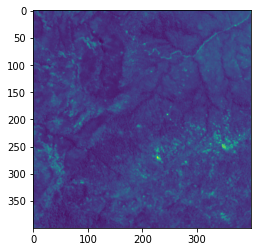

In [13]:
def get_nn_image(i,j,d):
    net = torch.load(f"{j:02d}_{i:02d}_net.pt", map_location='cpu')
    net.eval()
    input = torch.Tensor([1])
    return net(input).detach().numpy().reshape(-1,400,400) + np.load(f"{j:02d}_{i:02d}_mean.npy").reshape(400,400)
    
im = get_nn_image(11,4,0)
im.shape

plt.imshow(im[0,:,:])

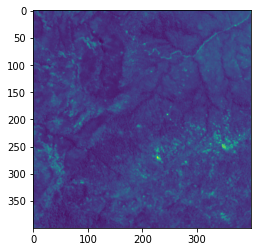

In [31]:
from numpy.lib.stride_tricks import as_strided

def conv2d(a, b):
    a = as_strided(a,(len(a),a.shape[1]-len(b)+1,a.shape[2]-b.shape[1]+1,len(b),
                      b.shape[1],a.shape[3]),a.strides[:3]+a.strides[1:])
    
    return np.tensordot(a, b, axes=3)

def get_nn_image(i,j,d):
    net = torch.load(f"{j:02d}_{i:02d}_net.pt", map_location='cpu')
    net.eval()
    base = net.D.weight.detach().numpy().reshape(1,12,404,404)
    ker = net.conv1.weight.detach().numpy()
    base = np.moveaxis(base,1,-1)
    ker = np.moveaxis(ker,1,-1)
    ker = np.moveaxis(ker,0,-1)
    
    conv1_dot = np.tanh(conv2d(base, ker))
    coeffs = net.coeffs.weight.detach().numpy().reshape(24,-1)[:,d].flatten()
    res = np.einsum('ik,kj->ji', conv1_dot.reshape(-1,24), coeffs.reshape(24,-1)).reshape(400,400)
    
    return res + np.load(f"{j:02d}_{i:02d}_mean.npy").reshape(400,400).astype(np.float32)
    
im = get_nn_image(11,4,0)
im.shape

plt.imshow(im)

11 3


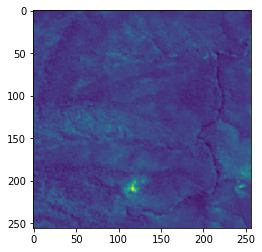

In [32]:
bbox=[16600899.551087722,-4189972.1424802206,16603345.535992848,-4187526.1575750955]
i0,i1,j0,j1 = bbox2tiles(bbox)

im_size = 256

pixel_size = ((bbox[2] - bbox[0]) / im_size, (bbox[3] - bbox[1]) / im_size)
    
tile_xs = np.arange(bbox[0], bbox[2], pixel_size[0])
tile_ys = np.arange(bbox[3], bbox[1], -pixel_size[1])
 
transformer = Transformer.from_crs(wm_proj, aea_proj)
aea_xs, aea_ys = transformer.transform(tile_xs, tile_ys)

arr = np.zeros((im_size,im_size), dtype=np.float32)
for i in range(i0, i1+1):
    for j in range(j0, j1+1):
        print(i, j)
        im = get_nn_image(i,j,0)
        geot = geotransform(i,j)

        vi = np.round((aea_xs - geot[0]) / geot[1]).astype(np.int64)
        vi[(vi>399) | (vi<0)] = -1
        vj = np.round((aea_ys - geot[3]) / geot[5]).astype(np.int64)
        vj[(vj>399) | (vj<0)] = -1

        for pj in range(im_size):
            for pi in range(im_size):
                if vi[pi] < 0 or vj[pj] < 0:
                    continue
                arr[pj,pi] = im[vj[pj],vi[pi]]
            
            
plt.imshow(arr)